In [7]:
import langchain
print(langchain.__version__)

0.3.4


In [8]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    answer: str  # 답변

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
import os

llm = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
)

# 관련성을 확인하는 함수, 단순히 True 또는 False를 반환
def check_question(state: GraphState) -> str:
    return "False"

#
def llm_answer(state: GraphState) -> GraphState:
    answer = llm.invoke(state["question"])  # 문자열로 질문을 전달
    return GraphState(
        question=state["question"],
        answer=answer,
    )

def rewrite(state):
    question = state["question"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to improve the question. Question must be written in same language. Don't narrate, just reponse an improved question.",
            ),
            (
                "human",
                "Look at the input and try to reason about the underlying semantic intent / meaning."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nFormulate an improved question:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    chain = prompt | model | StrOutputParser()
    response = chain.invoke({"question": question})
    return GraphState(
        question=response, answer=state["answer"]
    )


In [19]:
from langgraph.graph import END, StateGraph

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node("rewrite_question", rewrite)  # 질문을 재작성하는 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("rewrite_question", "llm_answer")  # 재작성 -> 관련성 체크
# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "llm_answer",  
    check_question,
    {
        "True": END,  # 관련성이 있으면 종료합니다.
        "False": "rewrite_question",  # 관련성이 없으면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("llm_answer")

# Workflow 설정에서 불필요한 메모리 체크포인트 및 조건부 엣지를 제거했습니다.
app = workflow.compile()


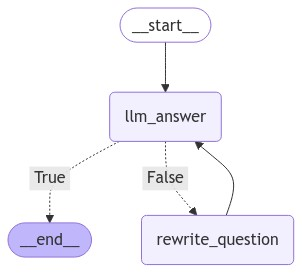

In [20]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [21]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=5, configurable={"thread_id": "CORRECTIVE-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="10월 31일 youtube/video 방문자수를 알려줘."
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'llm_answer':"
'---'
{ 'answer': AIMessage(content='죄송하지만, 특정 날짜의 YouTube 비디오 방문자 수와 같은 실시간 데이터나 특정 통계 정보를 제공할 수는 없습니다. YouTube의 방문자 수는 비공식적이며, 각 비디오의 조회수는 비디오 소유자나 YouTube의 공식 통계에서 확인할 수 있습니다. 특정 비디오의 조회수를 알고 싶다면 해당 비디오를 직접 확인해 보시기 바랍니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 20, 'total_tokens': 109, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-e0b4a0e8-1ef3-4609-9619-eb53e9129381-0', usage_metadata={'input_tokens': 20, 'output_tokens': 89, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  'question': '10월 31일 youtube/video